In [5]:
import os
import pandas as pd

base_path = 'output/yfinance_1m_bs_by_type_06/25'
bs_type_dfs = {}

for stock_code in os.listdir(base_path):
    stock_path = os.path.join(base_path, stock_code)
    if not os.path.isdir(stock_path):
        continue

    for fname in os.listdir(stock_path):
        if not fname.endswith('.csv'):
            continue

        bs_type = fname.replace('.csv', '')
        file_path = os.path.join(stock_path, fname)

        try:
            df = pd.read_csv(file_path)
            df['stock'] = stock_code
            df['bs_file_type'] = bs_type

            # 分类存储到字典里，避免混合特征
            if bs_type not in bs_type_dfs:
                bs_type_dfs[bs_type] = []

            bs_type_dfs[bs_type].append(df)
        except Exception as e:
            print(f"Failed to read {file_path}: {e}")

# 合并每个 bs_type 的 DataFrame
for bs_type in bs_type_dfs:
    bs_type_dfs[bs_type] = pd.concat(bs_type_dfs[bs_type], ignore_index=True)



[bs_features_type_1] 样本数: 1904, ACC: 0.675, AUC: 0.717
              precision    recall  f1-score   support

           0      0.505     0.392     0.441       125
           1      0.732     0.812     0.770       256

    accuracy                          0.675       381
   macro avg      0.619     0.602     0.606       381
weighted avg      0.658     0.675     0.662       381

[bs_features_type_1p] 样本数: 2222, ACC: 0.656, AUC: 0.693
              precision    recall  f1-score   support

           0      0.553     0.382     0.452       165
           1      0.692     0.818     0.750       280

    accuracy                          0.656       445
   macro avg      0.622     0.600     0.601       445
weighted avg      0.640     0.656     0.639       445

[bs_features_type_2] 样本数: 3770, ACC: 0.687, AUC: 0.729
              precision    recall  f1-score   support

           0      0.709     0.720     0.714       410
           1      0.660     0.648     0.654       344

    accuracy    

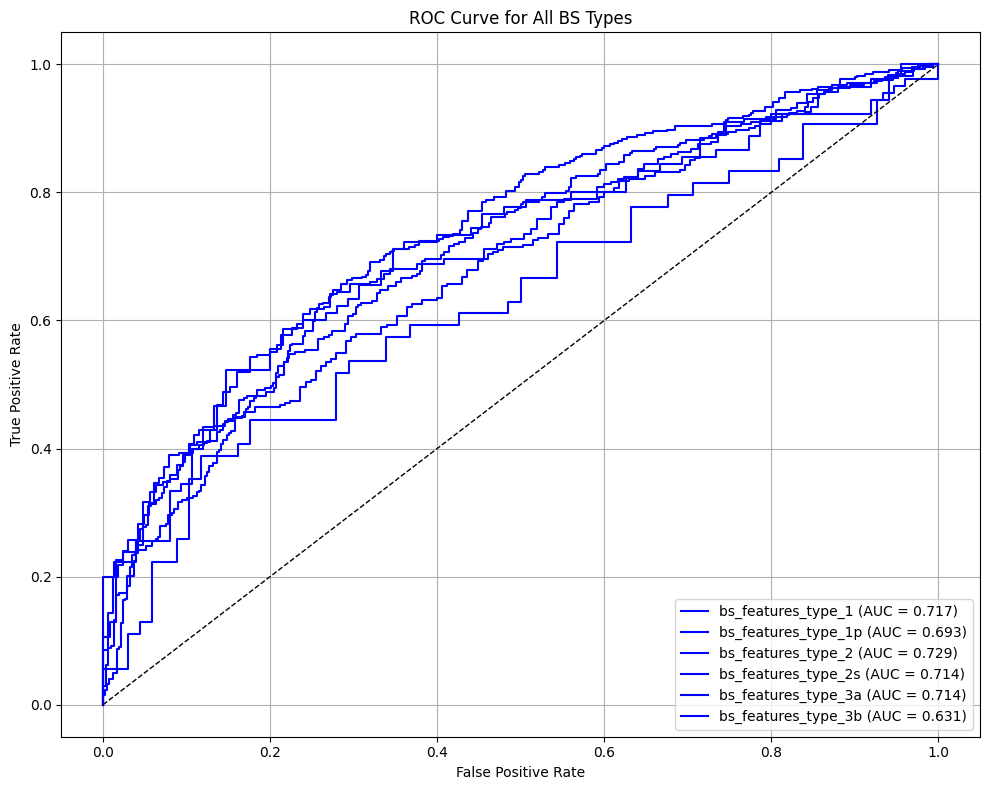

In [6]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score, roc_auc_score, accuracy_score, roc_curve, auc as sk_auc
import xgboost as xgb
import numpy as np

plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y']
threshold = 0.005  # 你可以调整成 0.003、0.01 等

for bs_type, df in bs_type_dfs.items():
    i = 0
    df = df.dropna(subset=['next_bi_return'])
    if len(df) < 50:
        print(f"跳过 {bs_type}，有效样本太少")
        continue
    df = df.copy()  # 添加这一行防止警告
    df['label'] = (df['next_bi_return'] > threshold).astype(int)


    exclude_cols = ['timestamp', 'stock', 'bs_file_type', 'next_bi_return', 'label', 'index']
    raw_features = [col for col in df.columns if col not in exclude_cols]
    num_features = df[raw_features].select_dtypes(include=[np.float64])

# 仅保留缺失率低于30%的特征
    valid_features = [col for col in num_features.columns if df[col].isna().mean() < 0.3]

# 构建最终特征与标签
    #print(X)
    X = df[valid_features]
    y = df['label']
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    if len(X) < 50:
        print(f"跳过 {bs_type}，清洗后样本仍太少")
        continue

    # 分训练集与测试集（注意 stratify 保持标签分布）
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # 分类模型参数
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_depth": 4,
        "eta": 0.1,
        "seed": 42
    }

    model = xgb.train(params, dtrain, num_boost_round=200)

    # 预测 + 评估
    y_pred_proba = model.predict(dtest)
    y_pred = (y_pred_proba > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"[{bs_type}] 样本数: {len(X)}, ACC: {acc:.3f}, AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred, digits=3))
        # 保存特征重要性
    importance = model.get_score(importance_type='gain')  # 可选：'weight', 'cover'
    importance_df = (
        pd.DataFrame({'Feature': list(importance.keys()), 'Importance': list(importance.values())})
        .sort_values(by='Importance', ascending=False)
    )

    # 创建保存目录
    save_dir = "feature_importance_classification"
    os.makedirs(save_dir, exist_ok=True)

    # 保存为 CSV
    importance_df.to_csv(f"{save_dir}/importance_{bs_type}.csv", index=False)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = sk_auc(fpr, tpr)


    plt.plot(fpr, tpr, color=colors[i],
             label=f'{bs_type} (AUC = {roc_auc:.3f})')
    i += 1


    # 可以继续绘制 ROC 和混淆矩阵等图表
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curve for All BS Types')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\TonyTang\AppData\Local\Temp\ipykernel_35336\3150730413.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(top_n), x='Importance', y='Feature', palette='Blues_d')


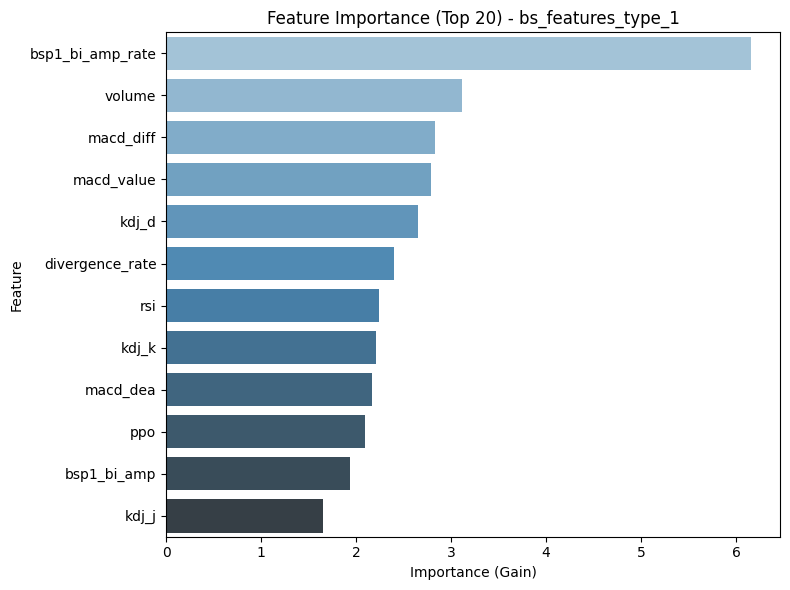

C:\Users\TonyTang\AppData\Local\Temp\ipykernel_35336\3150730413.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(top_n), x='Importance', y='Feature', palette='Blues_d')


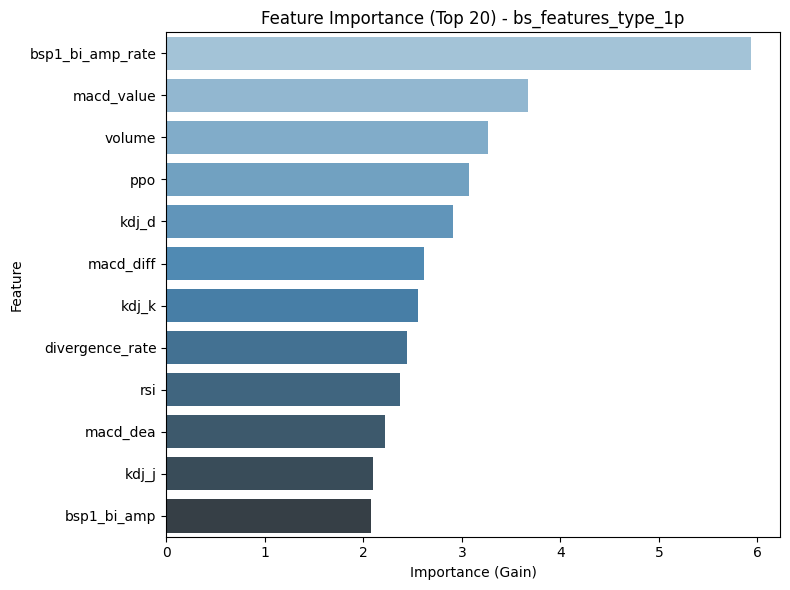

C:\Users\TonyTang\AppData\Local\Temp\ipykernel_35336\3150730413.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(top_n), x='Importance', y='Feature', palette='Blues_d')


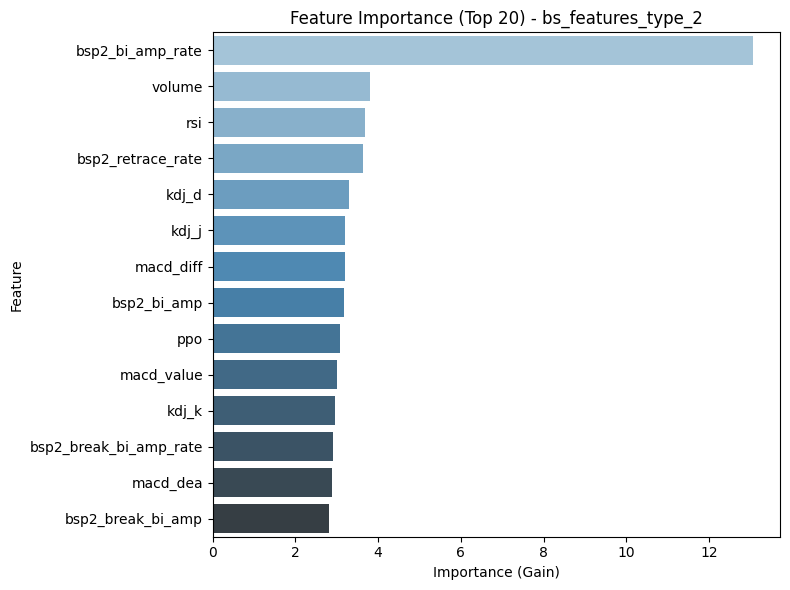

C:\Users\TonyTang\AppData\Local\Temp\ipykernel_35336\3150730413.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(top_n), x='Importance', y='Feature', palette='Blues_d')


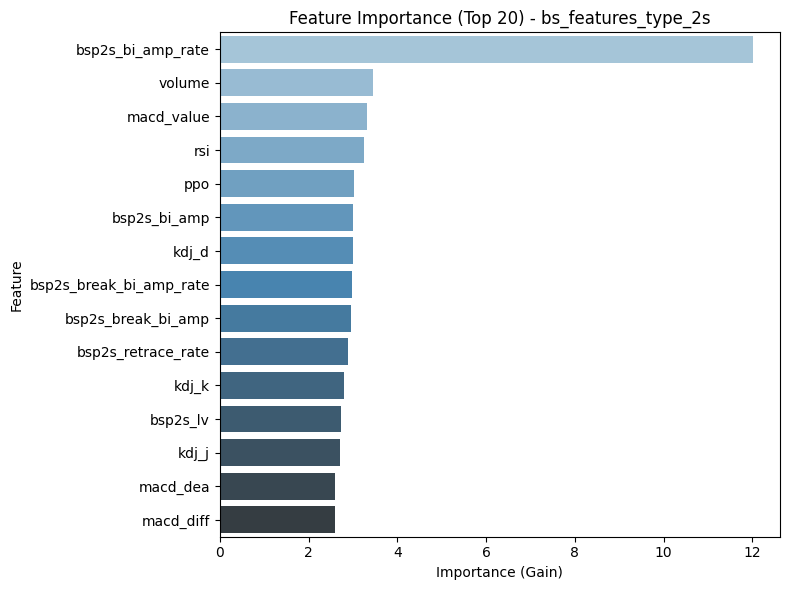

C:\Users\TonyTang\AppData\Local\Temp\ipykernel_35336\3150730413.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(top_n), x='Importance', y='Feature', palette='Blues_d')


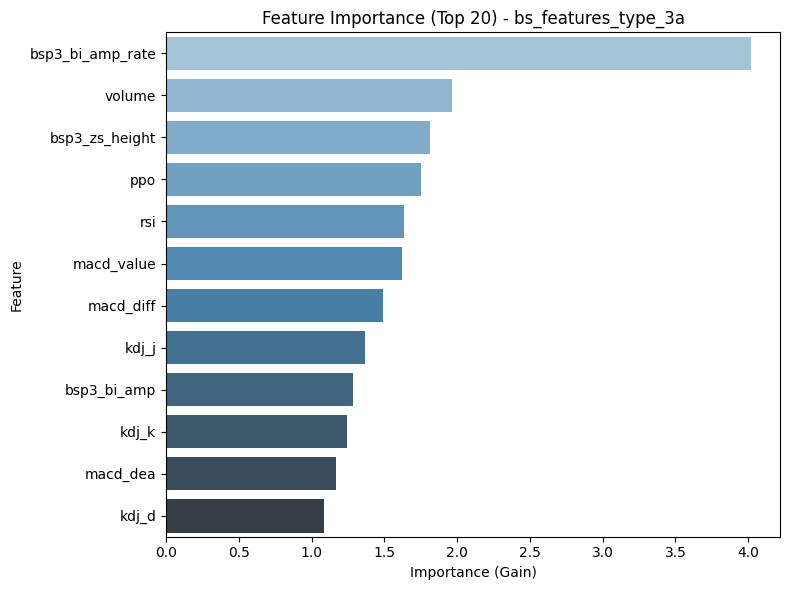

C:\Users\TonyTang\AppData\Local\Temp\ipykernel_35336\3150730413.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(top_n), x='Importance', y='Feature', palette='Blues_d')


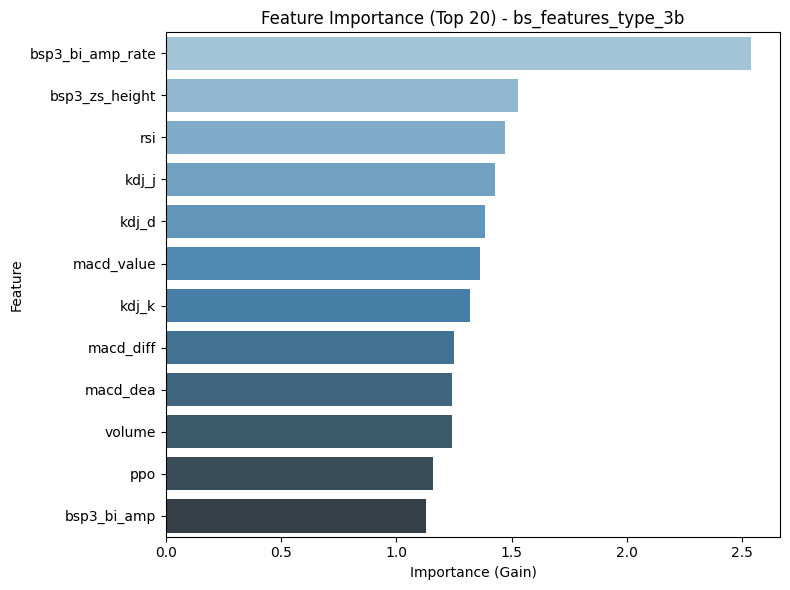

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置路径
importance_dir = "feature_importance_classification"
file_list = [f for f in os.listdir(importance_dir) if f.startswith("importance_") and f.endswith(".csv")]

# 遍历每个文件并绘图
for file_name in file_list:
    bs_type = file_name.replace("importance_", "").replace(".csv", "")
    file_path = os.path.join(importance_dir, file_name)

    try:
        df = pd.read_csv(file_path)
        if df.empty:
            print(f"{bs_type} 是空文件，跳过")
            continue

        top_n = 20
        plt.figure(figsize=(8, 6))
        sns.barplot(data=df.head(top_n), x='Importance', y='Feature', palette='Blues_d')
        plt.title(f'Feature Importance (Top {top_n}) - {bs_type}')
        plt.xlabel('Importance (Gain)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"读取 {file_name} 时出错: {e}")
